In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

noise_level_path = './2017_poblacio_exposada_barris_mapa_estrategic_soroll_bcn_long.csv'
rent_path = './2017_lloguer_preu_trim.csv'

rent = pd.read_csv(rent_path)
noise_level = pd.read_csv(noise_level_path)

In [3]:
df_pivoted = rent.pivot_table(index=['Any', 'Trimestre', 'Codi_Districte', 'Nom_Districte', 'Codi_Barri', 'Nom_Barri'],
                              columns='Lloguer_mitja',
                              values='Preu',
                              aggfunc='first').reset_index()

# Renombrar las columnas
df_pivoted.rename(columns={'Lloguer mitjà mensual (Euros/mes)': 'Precio_Mensual',
                          'Lloguer mitjà per superfície (Euros/m2 mes)': 'Precio_Por_Superficie'},
                 inplace=True)

# Si deseas combinar las dos columnas en un solo DataFrame, puedes hacerlo así
df_combined = df_pivoted[['Any', 'Trimestre', 'Codi_Districte', 'Nom_Districte', 'Codi_Barri', 'Nom_Barri', 'Precio_Mensual', 'Precio_Por_Superficie']]

rent = df_combined

In [4]:
# Computing middle value for Month price and m2 price

price_month=df_pivoted.groupby('Codi_Barri')['Precio_Mensual'].mean()
price_m2=df_pivoted.groupby('Codi_Barri')['Precio_Por_Superficie'].mean()

In [5]:
# Agrupar por distrito y barrio y calcular el promedio de Precio_Por_Superficie
rent_middle = df_pivoted.groupby(['Codi_Districte', 'Nom_Districte', 'Codi_Barri', 'Nom_Barri']).agg(
    Precio_Por_Superficie_Mean=('Precio_Por_Superficie', 'mean'),
    Precio_Mensual_Mean=('Precio_Mensual', 'mean')
).reset_index()

In [6]:
df_joined = rent_middle.merge(noise_level, on = ['Codi_Districte', 'Nom_Districte', 'Codi_Barri', 'Nom_Barri'])
to_drop = ['Codi_Districte', 'Codi_Barri']
for drop in to_drop:
    df_joined=df_joined.drop(drop,axis=1)

In [7]:
def transform_value(x):
    return np.float16(x.replace("%",""))/100
    
df_joined['Valor']=df_joined['Valor'].apply(transform_value)

df = df_joined.copy()

In [8]:
mapeo_rango_db = {
    '<40 dB': 30,
    '40-45 dB': 42.5,
    '45-50 dB': 47.5,
    '50-55 dB': 52.5,
    '55-60 dB': 57.5,
    '60-65 dB': 62.5,
    '65-70 dB': 67.5,
    '70-75 dB': 72.5,
    '75-80 dB': 77.5,
    '>=80 dB': 90 
}
df['Valor_Numerico'] = df['Rang_soroll'].map(mapeo_rango_db)
df['dB_Promig'] = df['Valor_Numerico'] * df['Valor']
df_dB = df.groupby(['Nom_Districte', 'Nom_Barri', 'Precio_Por_Superficie_Mean', 'Precio_Mensual_Mean', 'Concepte'])['dB_Promig'].sum().reset_index()

dum=pd.get_dummies(df_dB, columns=['Concepte'],prefix=['Concepte'])

In [11]:
df

,Nom_Districte,Nom_Barri,Precio_Por_Superficie_Mean,Precio_Mensual_Mean,Concepte,Rang_soroll,Valor,Valor_Numerico,dB_Promig
0,Ciutat Vella,el Raval,13.895,747.715,TOTAL_D,<40 dB,0.077305,30.0,2.319141
1,Ciutat Vella,el Raval,13.895,747.715,TOTAL_D,40-45 dB,0.269844,42.5,11.468359
2,Ciutat Vella,el Raval,13.895,747.715,TOTAL_D,45-50 dB,0.073789,47.5,3.504980
3,Ciutat Vella,el Raval,13.895,747.715,TOTAL_D,50-55 dB,0.119688,52.5,6.283594
4,Ciutat Vella,el Raval,13.895,747.715,TOTAL_D,55-60 dB,0.198437,57.5,11.410156
...,...,...,...,...,...,...,...,...,...
18195,Sant Martí,la Verneda i la Pau,10.165,688.610,PARCS_D,60-65 dB,0.000000,62.5,0.000000
18196,Sant Martí,la Verneda i la Pau,10.165,688.610,PARCS_D,65-70 dB,0.000000,67.5,0.000000
18197,Sant Martí,la Verneda i la Pau,10.165,688.610,PARCS_D,70-75 dB,0.000000,72.5,0.000000
18198,Sant Martí,la Verneda i la Pau,10.165,688.610,PARCS_D,75-80 dB,0.000000,77.5,0.000000


In [9]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

#Extract columns from characteristics
X = dum.drop(['Nom_Districte', 'Nom_Barri'], axis=1)

# Standarized values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [25]:
#Apply principal component analysis
pca = PCA(n_components=2)  
pca_result = pca.fit_transform(X)

y= [(str(distric), concept,str(db)) for distric, concept,db in zip(dum['Nom_Barri'], df['Concepte'],dum['dB_Promig'])]
y_district= [str(dist)for dist in zip(dum['Nom_Districte'])]




/var/folders/bf/0qbwqddj55lbd9qw7jt8m2bw0000gn/T/ipykernel_2388/1830231128.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('rainbow', len(barrios_unicos))


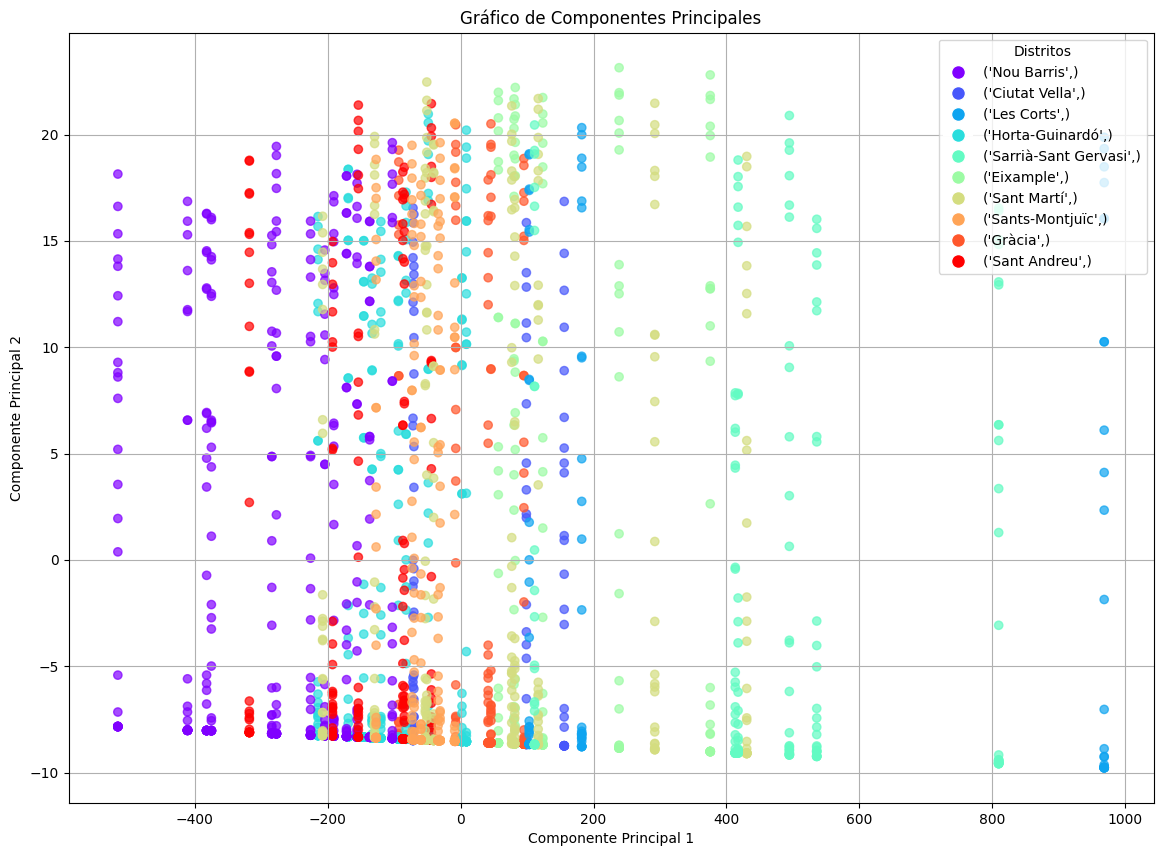

In [26]:
#Interactive funcionalities are not working for Jupyter Notebook (addded python script in the repo for interactive plot)
import matplotlib.pyplot as plt
import mplcursors  


colores = {}
barrios_unicos = set(y_district)
colormap = plt.cm.get_cmap('rainbow', len(barrios_unicos))
for i, barrio in enumerate(barrios_unicos):
    colores[barrio] = colormap(i / len(barrios_unicos))


fig, ax = plt.subplots(figsize=(14, 10))

scatter = ax.scatter(pca_result[:, 0], pca_result[:, 1], c=[colores[barrio] for barrio in y_district], alpha=0.7)

cursor = mplcursors.cursor(scatter, hover=True)
cursor.connect("add", lambda sel: sel.annotation.set_text(y[sel.target.index]))

legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=barrio, markersize=10, markerfacecolor=color) for barrio, color in colores.items()]
ax.legend(handles=legend_elements, title='Distritos', loc='upper right')

ax.set_xlabel('Componente Principal 1')
ax.set_ylabel('Componente Principal 2')
ax.set_title('Gráfico de Componentes Principales')
ax.grid(True)

plt.show()
